In [14]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
from astropy.io import fits
import tqdm

from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Colormap

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import cmasher as cm

import load_data as ld
import optimise as opt
import scatters as opt_sc
import init_latents as il
import kfold_cv as kf

import time

# load the data
file_name = '-test-rgbs'
spectra_dir_path = '../spec/spectra-reference-stars-APOGEE-giants-10K-ref/'
file_path = '../data/master-APOGEE-giants-test.fits'
spectra_data, label_data = ld.load_data(spectra_dir_path, file_path, file_name)


../spec/spectra-reference-stars-APOGEE-giants-10K-ref/spectra_data-test-rgbs.dat
File already exists. Loading spectra data


24it [00:00, 352.35it/s]

Loaded data successfully


In [2]:
test_ID = label_data['ids']
test_flux = spectra_data['fluxes']
test_flux_err = spectra_data['fluxes_err']
test_flux_ivar = spectra_data['fluxes_ivars']
test_label = label_data['labels']
test_label_err = label_data['labels_err']
test_label_ivar = label_data['labels_ivars']

In [3]:
l2reg = 1000
latent_dim = 'P49'
savepath = '../sav/paper/'
name = '_'+str(latent_dim)+'_L2regstrength'+str(l2reg)+'_omega1-train-highsnrgiants'
alphas = np.load(savepath+'alphas_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
betas = np.load(savepath+'betas_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
zetas = np.load(savepath+'zetas_train_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
ln_noise_fluxes_updated = jnp.log(np.load(savepath+'noise_fluxes_train_giants-withscatters'+str(name)+'.npy', allow_pickle=True))


# compute the new zetas for the test data, using both the labels and the flux

In [5]:
# first using the fluxes
P = 49
alphas_init_test, betas_init_test, zetas_init_test = il.initialise_alphas_betas_zetas(test_label, test_flux, P)

In [6]:
res_zetas_fromfluxes = opt_sc.get_zetas_test_using_fluxes(test_flux, test_flux_ivar, betas, zetas_init_test, ln_noise_fluxes_updated)
zetas_test_fromfluxes = res_zetas_fromfluxes.params['zetas']

INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 7986981453328.387, Curvature error: 8.576728365740841e+18


In [7]:
labels_test_fromflux = zetas_test_fromfluxes @ alphas.T
spectra_test_fromflux = zetas_test_fromfluxes @ betas.T

In [12]:
savepath = '../sav/paper/'
name = '_49_L2regstrength1000_omega1-train-highsnrgiants-3000maxiter'
np.save(savepath+'zetas_test_fromflux_giants-withscatters'+str(name), zetas_test_fromfluxes)
np.save(savepath+'labels_test_fromflux_giants-withscatters'+str(name), labels_test_fromflux)
np.save(savepath+'spectra_test_fromflux_giants-withscatters'+str(name), spectra_test_fromflux)


In [4]:
savepath = '../sav/paper/'
name = '_49_L2regstrength1000_omega1-train-highsnrgiants-3000maxiter'
zetas_test_fromfluxes = np.load(savepath+'zetas_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
labels_test_fromflux = np.load(savepath+'labels_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
spectra_test_fromflux = np.load(savepath+'spectra_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
labels_test_fromflux = zetas_test_fromfluxes @ alphas.T
spectra_test_fromflux = zetas_test_fromfluxes @ betas.T


# check the cross-validation of the labels

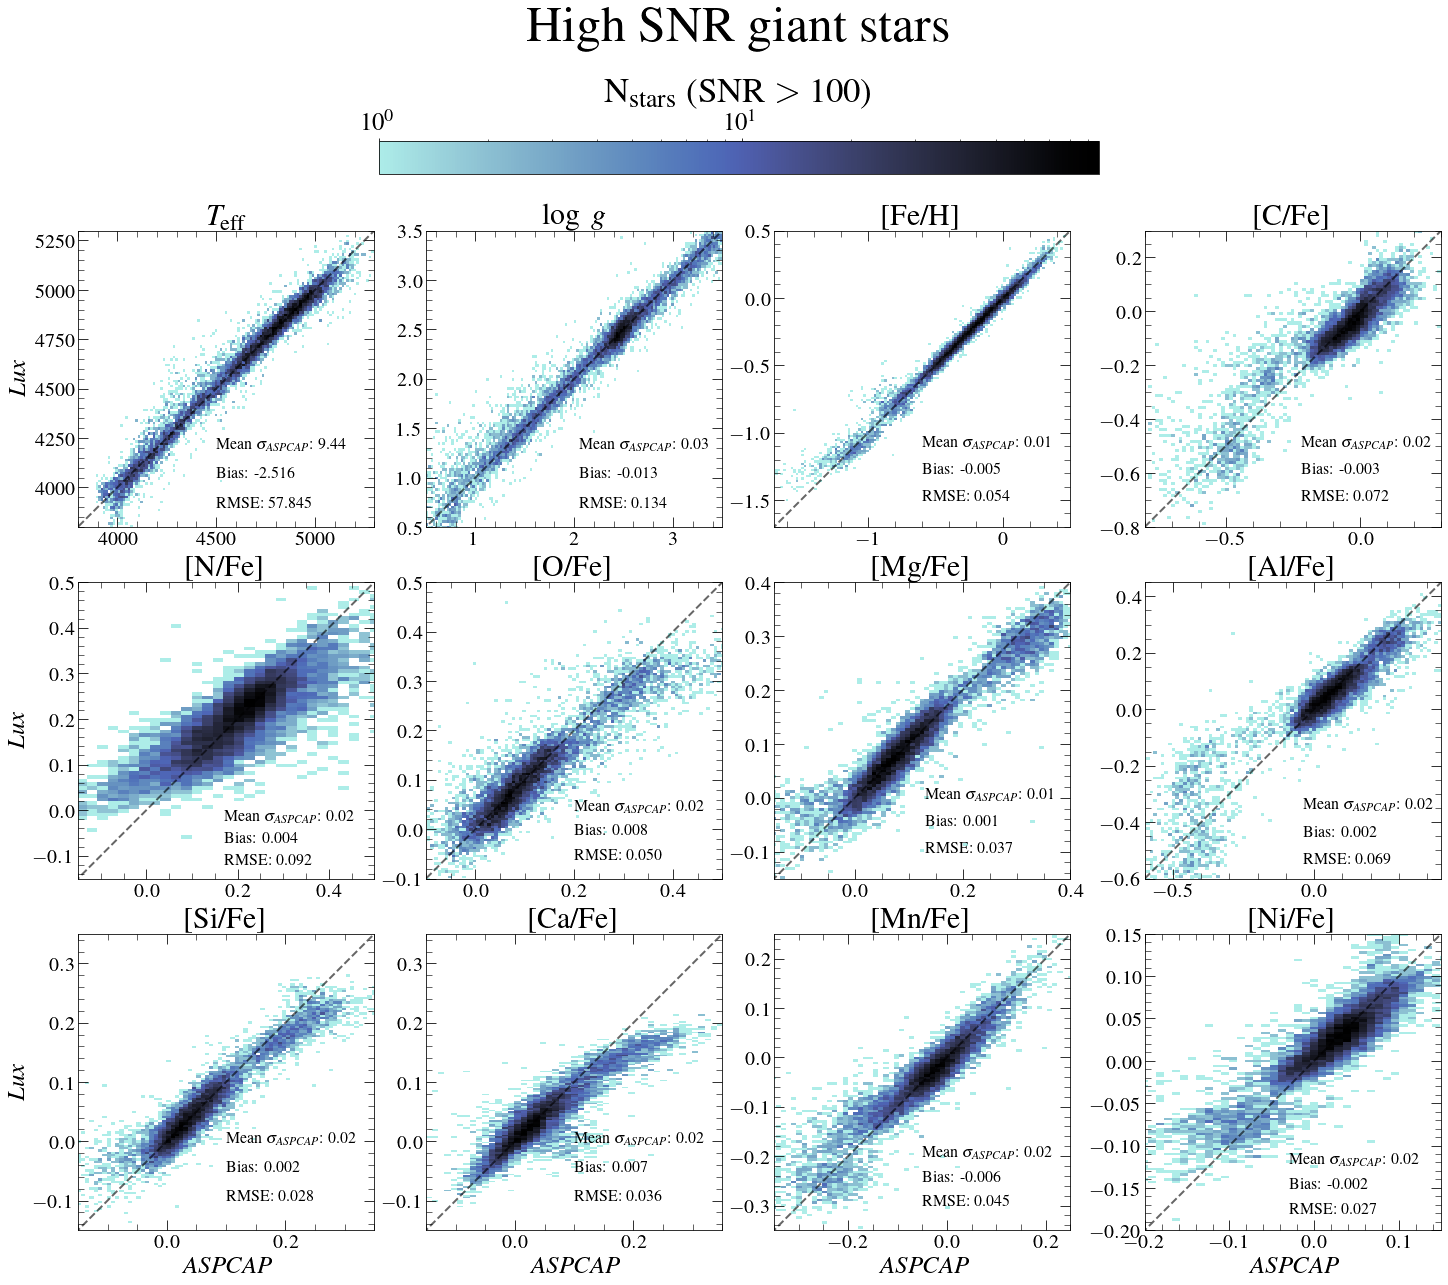

In [130]:
n = 10000
fig = plt.figure(figsize=(20,15), constrained_layout=True)
fig.suptitle('High SNR giant stars',fontsize=50,x=0.51,y=1.18)

plt.subplot(3,4,1)
plt.title('$T_{\mathrm{eff}}$', fontsize=30)
plt.plot([3500,5500], [3500,5500], color='k',alpha=0.6, lw=2, ls='dashed')
color = plt.hist2d(test_label[:n,0], labels_test_fromflux[:,0], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.text(4500,3900, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,0]-labels_test_fromflux[:,0])**2))))), fontsize=16)
plt.text(4500,4050, 'Bias: '+str("{:.3f}".format(jnp.median(test_label[:n,0]-labels_test_fromflux[:,0]))), fontsize=16)
plt.text(4500,4200, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,0]))), fontsize=16)
plt.xlim(3800,5300)
plt.ylim(3800,5300)
plt.ylabel(r'$Lux$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,2)
plt.title('$\log~g$', fontsize=30)
plt.plot([0,4],[0,4], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(2.05,0.7, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,1]-labels_test_fromflux[:,1])**2))))), fontsize=16)
plt.text(2.05,1.0, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,1]-labels_test_fromflux[:,1]))), fontsize=16)
plt.text(2.05,1.3, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,1]))), fontsize=16)
plt.hist2d(test_label[:n,1], labels_test_fromflux[:,1], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(0.5,3.5)
plt.ylim(0.5,3.5)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,3)
plt.title('[Fe/H]', fontsize=30)
plt.plot([-2,0.5], [-2,0.5], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,2]-labels_test_fromflux[:,2])**2))))), fontsize=16)
plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,2]-labels_test_fromflux[:,2]))), fontsize=16)
plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,2]))), fontsize=16)
plt.hist2d(test_label[:n,2], labels_test_fromflux[:,2], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-1.7,0.5)
plt.ylim(-1.7,0.5)
# plt.ylabel(r'The Paton', fontsize=20)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,4)
plt.title('[C/Fe]', fontsize=30)
plt.plot([-0.8,0.8], [-0.8,0.8], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.22,-0.7, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,3]-labels_test_fromflux[:,3])**2))))), fontsize=16)
plt.text(-0.22,-0.6, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,3]-labels_test_fromflux[:,3]))), fontsize=16)
plt.text(-0.22,-0.5, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,3]))), fontsize=16)
plt.hist2d(test_label[:n,3], labels_test_fromflux[:,3], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.8,0.3)
plt.ylim(-0.8,0.3)
# plt.xlabel(r'ASPCAP', fontsize=20)
# plt.ylabel(r'The Paton', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,5)
plt.title('[N/Fe]', fontsize=30)
plt.plot([-0.5,1.], [-0.5,1.], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.17,-0.12, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,4]-labels_test_fromflux[:,4])**2))))), fontsize=16)
plt.text(0.17,-0.07, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,4]-labels_test_fromflux[:,4]))), fontsize=16)
plt.text(0.17,-0.02, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,4]))), fontsize=16)
plt.hist2d(test_label[:n,4][np.abs(labels_test_fromflux[:,4])<0.5], labels_test_fromflux[:,4][np.abs(labels_test_fromflux[:,4])<0.5], bins=80, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.15,0.5)
plt.ylim(-0.15,0.5)
plt.ylabel(r'$Lux$', fontsize=25)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,6)
plt.title('[O/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.2,-0.06, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,5]-labels_test_fromflux[:,5])**2))))), fontsize=16)
plt.text(0.2,-0.01, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,5]-labels_test_fromflux[:,5]))), fontsize=16)
plt.text(0.2,0.04, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,5]))), fontsize=16)
plt.hist2d(test_label[:n,5], labels_test_fromflux[:,5], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.1,0.5)
plt.ylim(-0.1,0.5)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,7)
plt.title('[Mg/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.13,-0.1, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,6]-labels_test_fromflux[:,6])**2))))), fontsize=16)
plt.text(0.13,-0.05, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,6]-labels_test_fromflux[:,6]))), fontsize=16)
plt.text(0.13,0., 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,6]))), fontsize=16)
plt.hist2d(test_label[:n,6], labels_test_fromflux[:,6], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.15,0.4)
plt.ylim(-0.15,0.4)
# plt.ylabel(r'The Paton', fontsize=20)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,8)
plt.title('[Al/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.04,-0.55, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,7]-labels_test_fromflux[:,7])**2))))), fontsize=16)
plt.text(-0.04,-0.45, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,7]-labels_test_fromflux[:,7]))), fontsize=16)
plt.text(-0.04,-0.35, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,7]))), fontsize=16)
plt.hist2d(test_label[:n,7], labels_test_fromflux[:,7], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.6,0.45)
plt.ylim(-0.6,0.45)
# plt.ylabel(r'The Paton', fontsize=20)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,9)
plt.title('[Si/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.1,-0.1, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,8]-labels_test_fromflux[:,8])**2))))), fontsize=16)
plt.text(0.1,-0.05, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,8]-labels_test_fromflux[:,8]))), fontsize=16)
plt.text(0.1,0.0, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,8]))), fontsize=16)
plt.hist2d(test_label[:n,8], labels_test_fromflux[:,8], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.15,0.35)
plt.ylim(-0.15,0.35)
plt.ylabel(r'$Lux$', fontsize=25)
plt.xlabel(r'$ASPCAP$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,10)
plt.title('[Ca/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.1,-0.1, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,9]-labels_test_fromflux[:,9])**2))))), fontsize=16)
plt.text(0.1,-0.05, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,9]-labels_test_fromflux[:,9]))), fontsize=16)
plt.text(0.1,0., 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,9][np.abs(test_label_err[:n,9])<1]))), fontsize=16)
plt.hist2d(test_label[:n,9], labels_test_fromflux[:,9], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.15,0.35)
plt.ylim(-0.15,0.35)
# plt.ylabel(r'The Paton', fontsize=25)
plt.xlabel(r'$ASPCAP$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,11)
plt.title('[Mn/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.05,-0.3, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,10]-labels_test_fromflux[:,10])**2))))), fontsize=16)
plt.text(-0.05,-0.25, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,10]-labels_test_fromflux[:,10]))), fontsize=16)
plt.text(-0.05,-0.2, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,10]))), fontsize=16)
plt.hist2d(test_label[:n,10], labels_test_fromflux[:,10], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.35,0.25)
plt.ylim(-0.35,0.25)
# plt.ylabel(r'The Paton', fontsize=20)
plt.xlabel(r'$ASPCAP$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,12)
plt.title('[Ni/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.03,-0.18, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,11]-labels_test_fromflux[:,11])**2))))), fontsize=16)
plt.text(-0.03,-0.15, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,11]-labels_test_fromflux[:,11]))), fontsize=16)
plt.text(-0.03,-0.12, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,11]))), fontsize=16)
plt.hist2d(test_label[:n,11], labels_test_fromflux[:,11], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.2,0.15)
plt.ylim(-0.2,0.15)
# plt.ylabel(r'The Paton', fontsize=20)
plt.xlabel(r'$ASPCAP$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.26, 1.025, 0.5,0.03])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'N$_{\mathrm{stars}}$ (SNR $>100$)',fontsize=35,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.savefig('../plots/paper/CV-test-highsnr-lux.pdf',dpi=200, bbox_inches = 'tight')

In [5]:
# LOAD THE DATA
path = '../data/master-APOGEE-giants-test-orbits.fits'
tb = fits.open(path)
data = tb[1].data 

In [6]:
savepath = '../sav/paper/'
name = 'Cannon_trained'
labels_cannon = np.load(savepath+str(name)+'labels-test.npy', allow_pickle=True)

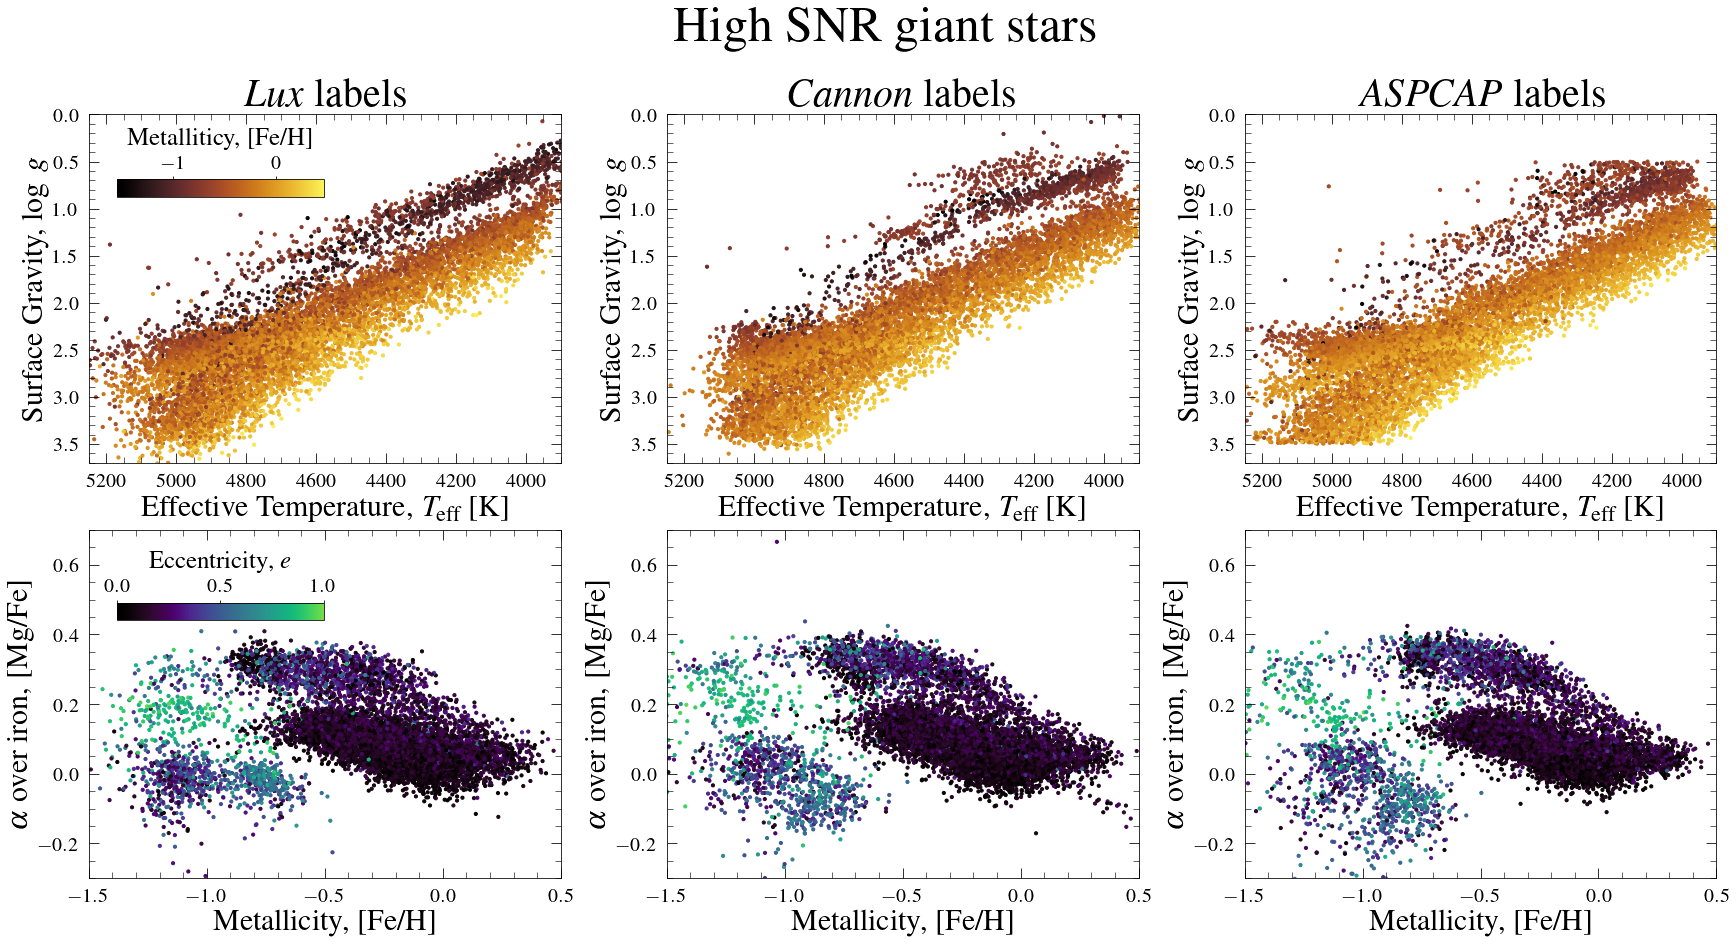

In [7]:

fig = plt.figure(figsize=(24,12),facecolor='white',constrained_layout=True,rasterized=True)
fig.suptitle('High SNR giant stars',fontsize=50,x=0.51,y=1.08)

plt.subplot(2,3,1)
plt.title('$Lux$ labels', fontsize=40)
color = plt.scatter(labels_test_fromflux[:,0],labels_test_fromflux[:,1], c=labels_test_fromflux[:,2], cmap=cm.amber,s=10)
plt.xlim(5250,3900)
plt.ylim(3.7,0.)
plt.xlabel('Effective Temperature, $T_{\mathrm{eff}}$ [K]',fontsize=30)
plt.ylabel('Surface Gravity, $\log~g$',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.065, 0.86, 0.12,0.02])
cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
cbar.set_label(label=r'Metalliticy, [Fe/H]',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=20)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')


plt.subplot(2,3,2)
plt.title('$Cannon$ labels', fontsize=40)
color = plt.scatter(labels_cannon[:,0],labels_cannon[:,1], c=labels_cannon[:,2], cmap=cm.amber,s=10)
plt.xlim(5250,3900)
plt.ylim(3.7,0.)
plt.xlabel('Effective Temperature, $T_{\mathrm{eff}}$ [K]',fontsize=30)
plt.ylabel('Surface Gravity, $\log~g$',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,3)
plt.title('$ASPCAP$ labels', fontsize=40)
color = plt.scatter(test_label[:,0],test_label[:,1], c=test_label[:,2], cmap=cm.amber,s=10)
plt.xlim(5250,3900)
plt.ylim(3.7,0.)
plt.xlabel('Effective Temperature, $T_{\mathrm{eff}}$ [K]',fontsize=30)
plt.ylabel('Surface Gravity, $\log~g$',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()


plt.subplot(2,3,4)
color = plt.scatter(labels_test_fromflux[:,2],labels_test_fromflux[:,6], c=data['ecc'], cmap=cm.lavender,s=10, vmin=0,vmax=1)
plt.xlim(-1.5,0.5)
plt.ylim(-0.3,0.7)
plt.xlabel('Metallicity, [Fe/H]',fontsize=30)
plt.ylabel(r'$\alpha$ over iron, [Mg/Fe]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.065, 0.37, 0.12,0.02])
cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
cbar.set_label(label=r'Eccentricity, $e$',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=20)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.subplot(2,3,5)
# color = plt.scatter(test_label[:5000][:,2][:5000],test_label[:,6][:5000], c=label_data['snr'][:5000], cmap=cm.cosmic,s=20, vmin=100,vmax=300)
color = plt.scatter(labels_cannon[:,2],labels_cannon[:,6], c=data['ecc'], cmap=cm.lavender,s=10, vmin=0,vmax=1)
plt.xlim(-1.5,0.5)
plt.ylim(-0.3,0.7)
plt.xlabel('Metallicity, [Fe/H]',fontsize=30)
plt.ylabel(r'$\alpha$ over iron, [Mg/Fe]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,6)
# color = plt.scatter(test_label[:5000][:,2][:5000],test_label[:,6][:5000], c=label_data['snr'][:5000], cmap=cm.cosmic,s=20, vmin=100,vmax=300)
color = plt.scatter(test_label[:,2],test_label[:,6], c=data['ecc'], cmap=cm.lavender,s=10, vmin=0,vmax=1)
plt.xlim(-1.5,0.5)
plt.ylim(-0.3,0.7)
plt.xlabel('Metallicity, [Fe/H]',fontsize=30)
plt.ylabel(r'$\alpha$ over iron, [Mg/Fe]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('../plots/paper/kiel-test-cannon-Lux.pdf',dpi=200, bbox_inches = 'tight')


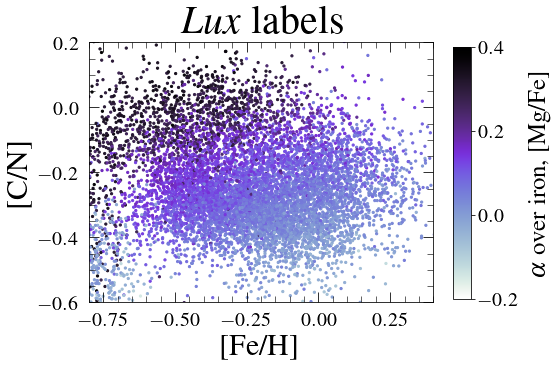

In [8]:
fig = plt.figure(figsize=(6,5),facecolor='white',constrained_layout=True,rasterized=True)

plt.title('$Lux$ labels', fontsize=40)
color = plt.scatter(labels_test_fromflux[:,2],labels_test_fromflux[:,3]-labels_test_fromflux[:,4], c=labels_test_fromflux[:,6], cmap=cm.amethyst_r,s=5, vmin=-0.2, vmax=0.4)
plt.xlim(-0.8,0.4)
plt.ylim(-0.6,0.2)
plt.xlabel('[Fe/H]',fontsize=30)
plt.ylabel('[C/N]',fontsize=30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([1.04, 0.18, 0.04,0.7])
cbar = fig.colorbar(color, cax = cbar_ax,orientation='vertical')
cbar.set_label(label=r'$\alpha$ over iron, [Mg/Fe]',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=20)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.savefig('../plots/paper/cn.pdf',dpi=200, bbox_inches = 'tight')



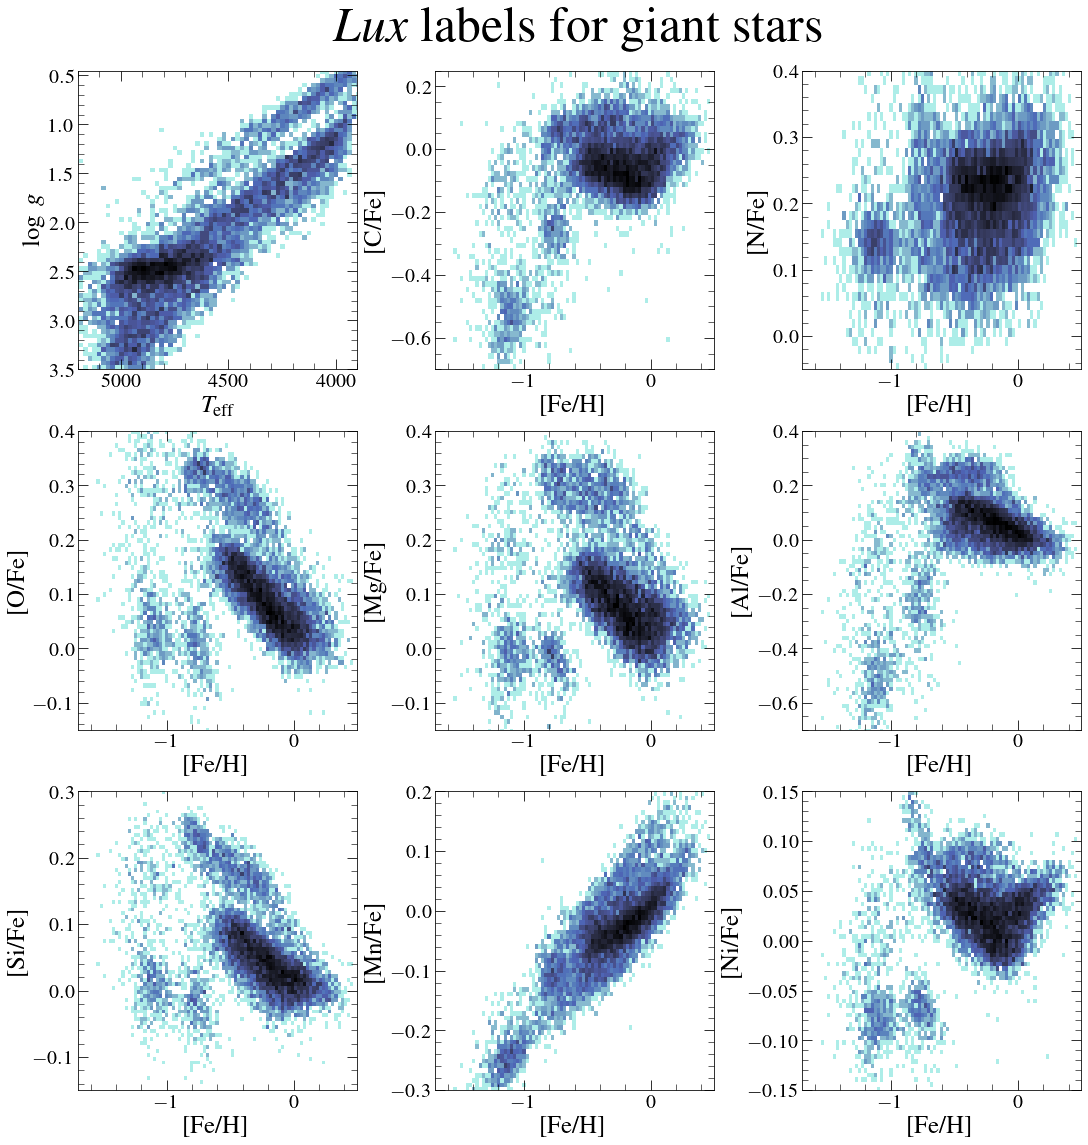

In [9]:
n = 10000
fig = plt.figure(figsize=(15,15), constrained_layout=True)
fig.suptitle('$Lux$ labels for giant stars',fontsize=50,x=0.53,y=1.05)

plt.subplot(3,3,1)
color = plt.hist2d(labels_test_fromflux[:,0], labels_test_fromflux[:,1], bins=82, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(5200,3900)
plt.ylim(3.5,0.45)
plt.xlabel(r'$T_{\mathrm{eff}}$', fontsize=25)
plt.ylabel(r'$\log~g$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,3,2)
color = plt.hist2d(labels_test_fromflux[:,2], labels_test_fromflux[:,3], bins=82, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-1.7,0.5)
plt.ylim(-0.7,0.25)
plt.xlabel(r'[Fe/H]', fontsize=25)
plt.ylabel(r'[C/Fe]', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,3,3)
color = plt.hist2d(labels_test_fromflux[:,2], labels_test_fromflux[:,4], bins=82, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-1.7,0.5)
plt.ylim(-0.05,0.4)
plt.xlabel(r'[Fe/H]', fontsize=25)
plt.ylabel(r'[N/Fe]', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,3,4)
color = plt.hist2d(labels_test_fromflux[:,2], labels_test_fromflux[:,5], bins=82, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-1.7,0.5)
plt.ylim(-0.15,0.4)
plt.xlabel(r'[Fe/H]', fontsize=25)
plt.ylabel(r'[O/Fe]', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,3,5)
color = plt.hist2d(labels_test_fromflux[:,2], labels_test_fromflux[:,6], bins=82, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-1.7,0.5)
plt.ylim(-0.15,0.4)
plt.xlabel(r'[Fe/H]', fontsize=25)
plt.ylabel(r'[Mg/Fe]', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,3,6)
color = plt.hist2d(labels_test_fromflux[:,2], labels_test_fromflux[:,7], bins=82, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-1.7,0.5)
plt.ylim(-0.7,0.4)
plt.xlabel(r'[Fe/H]', fontsize=25)
plt.ylabel(r'[Al/Fe]', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,3,7)
color = plt.hist2d(labels_test_fromflux[:,2], labels_test_fromflux[:,8], bins=82, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-1.7,0.5)
plt.ylim(-0.15,0.3)
plt.xlabel(r'[Fe/H]', fontsize=25)
plt.ylabel(r'[Si/Fe]', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,3,8)
color = plt.hist2d(labels_test_fromflux[:,2], labels_test_fromflux[:,10], bins=82, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-1.7,0.5)
plt.ylim(-0.3,0.2)
plt.xlabel(r'[Fe/H]', fontsize=25)
plt.ylabel(r'[Mn/Fe]', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,3,9)
color = plt.hist2d(labels_test_fromflux[:,2], labels_test_fromflux[:,11], bins=82, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-1.7,0.5)
plt.ylim(-0.15,0.15)
plt.xlabel(r'[Fe/H]', fontsize=25)
plt.ylabel(r'[Ni/Fe]', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('../plots/paper/paton-labels-allabun-Lux.pdf',dpi=200, bbox_inches = 'tight')

# now compute the zetas using the labels

In [11]:
# first using the fluxes
P = 49
alphas_init_test, betas_init_test, zetas_init_test = il.initialise_alphas_betas_zetas(test_label, test_flux, P)

In [29]:
def get_zetas_test_using_labels(labels, labels_ivars, alphas, zetas):
        """
                Function to optimise the zetas latents parameters at fixes alphas using the labels and labels ivars
                INPUT: 
                        alphas: latent parameters for labels, M x P
                        zetas: latent parameters, N x P
                        labels: fluxes for all stars, N x M
                        labels_ivar: label inverse variances for all stars, N x M
                OUTPUT:
                        optimised zetas
        """

        params, data = opt_sc.get_data_zeta_test_using_labels(labels, labels_ivars, alphas, zetas)

        optimizer = jaxopt.LBFGS(fun=opt_sc.all_labels_all_stars_objective_test, tol=1e-6, maxiter=3000, max_stepsize=1e3) # magic numbers

        res = optimizer.run(init_params = params, data = data)

        return res

In [30]:
res_zetas_fromlabels = get_zetas_test_using_labels(test_label, test_label_ivar, alphas, zetas_init_test)
zetas_test_fromlabels = res_zetas_fromlabels.params['zetas']

INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 1603003913.6367054, Curvature error: 1723404085134257.0


In [31]:
labels_test_fromlabels = zetas_test_fromlabels @ alphas.T
spectra_test_fromlabels = zetas_test_fromlabels @ betas.T

In [32]:
savepath = '../sav/paper/'
name = '_P49_L2regstrength1000_omega1-train-highsnrgiants-3000maxiter'
np.save(savepath+'zetas_test_fromlabels_giants-withscatters'+str(name), zetas_test_fromlabels)
np.save(savepath+'labels_test_fromlabels_giants-withscatters'+str(name), labels_test_fromlabels)
np.save(savepath+'spectra_test_fromlabels_giants-withscatters'+str(name), spectra_test_fromlabels)

In [10]:
savepath = '../sav/paper/'
name = '_P49_L2regstrength1000_omega1-train-highsnrgiants-3000maxiter'
zetas_test_fromlabels = np.load(savepath+'zetas_test_fromlabels_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
labels_test_fromlabels = np.load(savepath+'labels_test_fromlabels_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
spectra_test_fromlabels = np.load(savepath+'spectra_test_fromlabels_giants-withscatters'+str(name)+'.npy', allow_pickle=True)

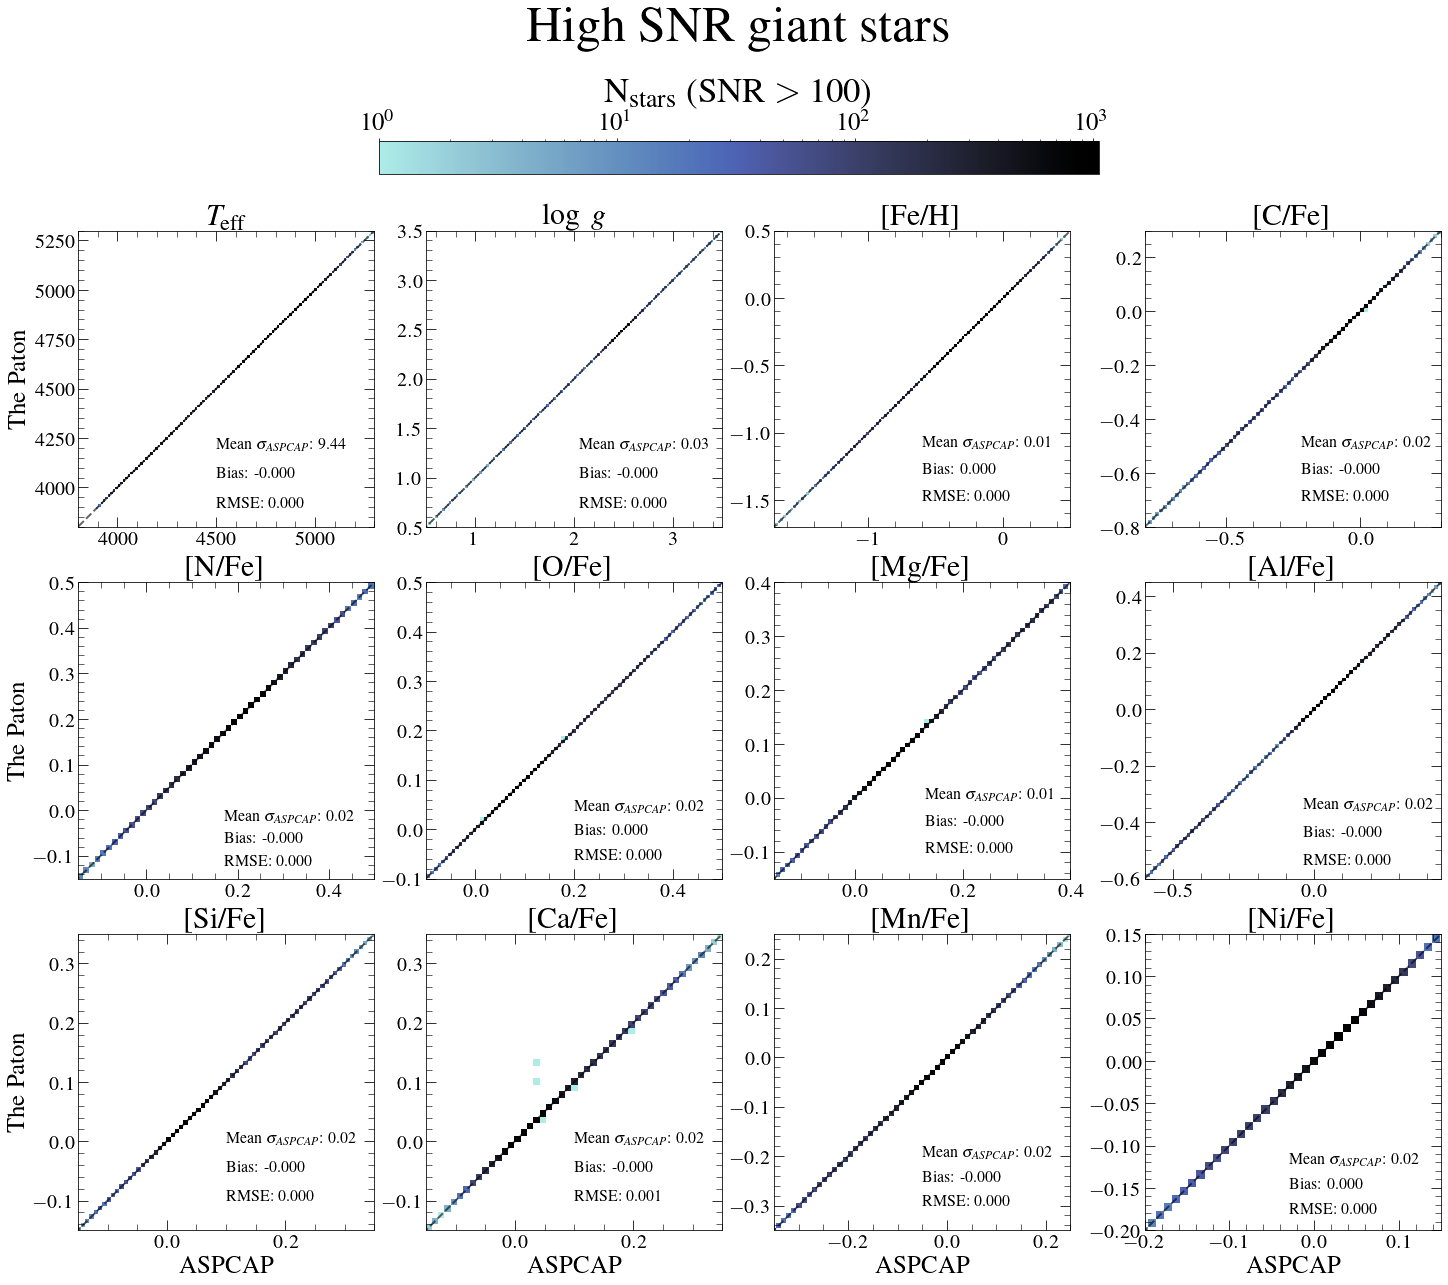

In [34]:
n = 10000
fig = plt.figure(figsize=(20,15), constrained_layout=True)
fig.suptitle('High SNR giant stars',fontsize=50,x=0.51,y=1.18)

plt.subplot(3,4,1)
plt.title('$T_{\mathrm{eff}}$', fontsize=30)
plt.plot([3500,5500], [3500,5500], color='k',alpha=0.6, lw=2, ls='dashed')
color = plt.hist2d(test_label[:n,0], labels_test_fromlabels[:,0], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.text(4500,3900, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,0]-labels_test_fromlabels[:,0])**2))))), fontsize=16)
plt.text(4500,4050, 'Bias: '+str("{:.3f}".format(jnp.median(test_label[:n,0]-labels_test_fromlabels[:,0]))), fontsize=16)
plt.text(4500,4200, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,0]))), fontsize=16)
plt.xlim(3800,5300)
plt.ylim(3800,5300)
plt.ylabel(r'The Paton', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,2)
plt.title('$\log~g$', fontsize=30)
plt.plot([0,4],[0,4], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(2.05,0.7, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,1]-labels_test_fromlabels[:,1])**2))))), fontsize=16)
plt.text(2.05,1.0, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,1]-labels_test_fromlabels[:,1]))), fontsize=16)
plt.text(2.05,1.3, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,1]))), fontsize=16)
plt.hist2d(test_label[:n,1], labels_test_fromlabels[:,1], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(0.5,3.5)
plt.ylim(0.5,3.5)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,3)
plt.title('[Fe/H]', fontsize=30)
plt.plot([-2,0.5], [-2,0.5], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,2]-labels_test_fromlabels[:,2])**2))))), fontsize=16)
plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,2]-labels_test_fromlabels[:,2]))), fontsize=16)
plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,2]))), fontsize=16)
plt.hist2d(test_label[:n,2], labels_test_fromlabels[:,2], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-1.7,0.5)
plt.ylim(-1.7,0.5)
# plt.ylabel(r'The Paton', fontsize=20)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,4)
plt.title('[C/Fe]', fontsize=30)
plt.plot([-0.8,0.8], [-0.8,0.8], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.22,-0.7, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,3]-labels_test_fromlabels[:,3])**2))))), fontsize=16)
plt.text(-0.22,-0.6, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,3]-labels_test_fromlabels[:,3]))), fontsize=16)
plt.text(-0.22,-0.5, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,3]))), fontsize=16)
plt.hist2d(test_label[:n,3], labels_test_fromlabels[:,3], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.8,0.3)
plt.ylim(-0.8,0.3)
# plt.xlabel(r'ASPCAP', fontsize=20)
# plt.ylabel(r'The Paton', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,5)
plt.title('[N/Fe]', fontsize=30)
plt.plot([-0.5,1.], [-0.5,1.], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.17,-0.12, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,4]-labels_test_fromlabels[:,4])**2))))), fontsize=16)
plt.text(0.17,-0.07, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,4]-labels_test_fromlabels[:,4]))), fontsize=16)
plt.text(0.17,-0.02, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,4]))), fontsize=16)
plt.hist2d(test_label[:n,4][np.abs(labels_test_fromlabels[:,4])<0.5], labels_test_fromlabels[:,4][np.abs(labels_test_fromlabels[:,4])<0.5], bins=80, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.15,0.5)
plt.ylim(-0.15,0.5)
plt.ylabel(r'The Paton', fontsize=25)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,6)
plt.title('[O/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.2,-0.06, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,5]-labels_test_fromlabels[:,5])**2))))), fontsize=16)
plt.text(0.2,-0.01, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,5]-labels_test_fromlabels[:,5]))), fontsize=16)
plt.text(0.2,0.04, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,5]))), fontsize=16)
plt.hist2d(test_label[:n,5], labels_test_fromlabels[:,5], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.1,0.5)
plt.ylim(-0.1,0.5)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,7)
plt.title('[Mg/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.13,-0.1, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,6]-labels_test_fromlabels[:,6])**2))))), fontsize=16)
plt.text(0.13,-0.05, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,6]-labels_test_fromlabels[:,6]))), fontsize=16)
plt.text(0.13,0., 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,6]))), fontsize=16)
plt.hist2d(test_label[:n,6], labels_test_fromlabels[:,6], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.15,0.4)
plt.ylim(-0.15,0.4)
# plt.ylabel(r'The Paton', fontsize=20)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,8)
plt.title('[Al/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.04,-0.55, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,7]-labels_test_fromlabels[:,7])**2))))), fontsize=16)
plt.text(-0.04,-0.45, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,7]-labels_test_fromlabels[:,7]))), fontsize=16)
plt.text(-0.04,-0.35, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,7]))), fontsize=16)
plt.hist2d(test_label[:n,7], labels_test_fromlabels[:,7], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.6,0.45)
plt.ylim(-0.6,0.45)
# plt.ylabel(r'The Paton', fontsize=20)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,9)
plt.title('[Si/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.1,-0.1, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,8]-labels_test_fromlabels[:,8])**2))))), fontsize=16)
plt.text(0.1,-0.05, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,8]-labels_test_fromlabels[:,8]))), fontsize=16)
plt.text(0.1,0.0, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,8]))), fontsize=16)
plt.hist2d(test_label[:n,8], labels_test_fromlabels[:,8], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.15,0.35)
plt.ylim(-0.15,0.35)
plt.ylabel(r'The Paton', fontsize=25)
plt.xlabel(r'ASPCAP', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,10)
plt.title('[Ca/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.1,-0.1, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,9]-labels_test_fromlabels[:,9])**2))))), fontsize=16)
plt.text(0.1,-0.05, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,9]-labels_test_fromlabels[:,9]))), fontsize=16)
plt.text(0.1,0., 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,9][np.abs(test_label_err[:n,9])<1]))), fontsize=16)
plt.hist2d(test_label[:n,9], labels_test_fromlabels[:,9], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.15,0.35)
plt.ylim(-0.15,0.35)
# plt.ylabel(r'The Paton', fontsize=25)
plt.xlabel(r'ASPCAP', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,11)
plt.title('[Mn/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.05,-0.3, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,10]-labels_test_fromlabels[:,10])**2))))), fontsize=16)
plt.text(-0.05,-0.25, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,10]-labels_test_fromlabels[:,10]))), fontsize=16)
plt.text(-0.05,-0.2, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,10]))), fontsize=16)
plt.hist2d(test_label[:n,10], labels_test_fromlabels[:,10], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.35,0.25)
plt.ylim(-0.35,0.25)
# plt.ylabel(r'The Paton', fontsize=20)
plt.xlabel(r'ASPCAP', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,12)
plt.title('[Ni/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.03,-0.18, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,11]-labels_test_fromlabels[:,11])**2))))), fontsize=16)
plt.text(-0.03,-0.15, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,11]-labels_test_fromlabels[:,11]))), fontsize=16)
plt.text(-0.03,-0.12, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,11]))), fontsize=16)
plt.hist2d(test_label[:n,11], labels_test_fromlabels[:,11], bins=128, rasterized=True,  cmap=cm.sapphire_r, norm = LogNorm())
plt.xlim(-0.2,0.15)
plt.ylim(-0.2,0.15)
# plt.ylabel(r'The Paton', fontsize=20)
plt.xlabel(r'ASPCAP', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.26, 1.025, 0.5,0.03])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'N$_{\mathrm{stars}}$ (SNR $>100$)',fontsize=35,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.savefig('../plots/paper/CV-test-highsnr-usinglabels.pdf',dpi=200, bbox_inches = 'tight')

# now check the spectra

In [11]:
savepath = '../sav/paper/'
name = '_P49_L2regstrength1000_omega1-train-highsnrgiants-3000maxiter'
zetas_test_fromlabels = np.load(savepath+'zetas_test_fromlabels_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
labels_test_fromlabels = np.load(savepath+'labels_test_fromlabels_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
spectra_test_fromlabels = np.load(savepath+'spectra_test_fromlabels_giants-withscatters'+str(name)+'.npy', allow_pickle=True)


2M00204904-7133587
2M00055986+6850184
2M00002926+5737333
2M00101602+0154424
2M00052512+5642535
2M01233689+6233205


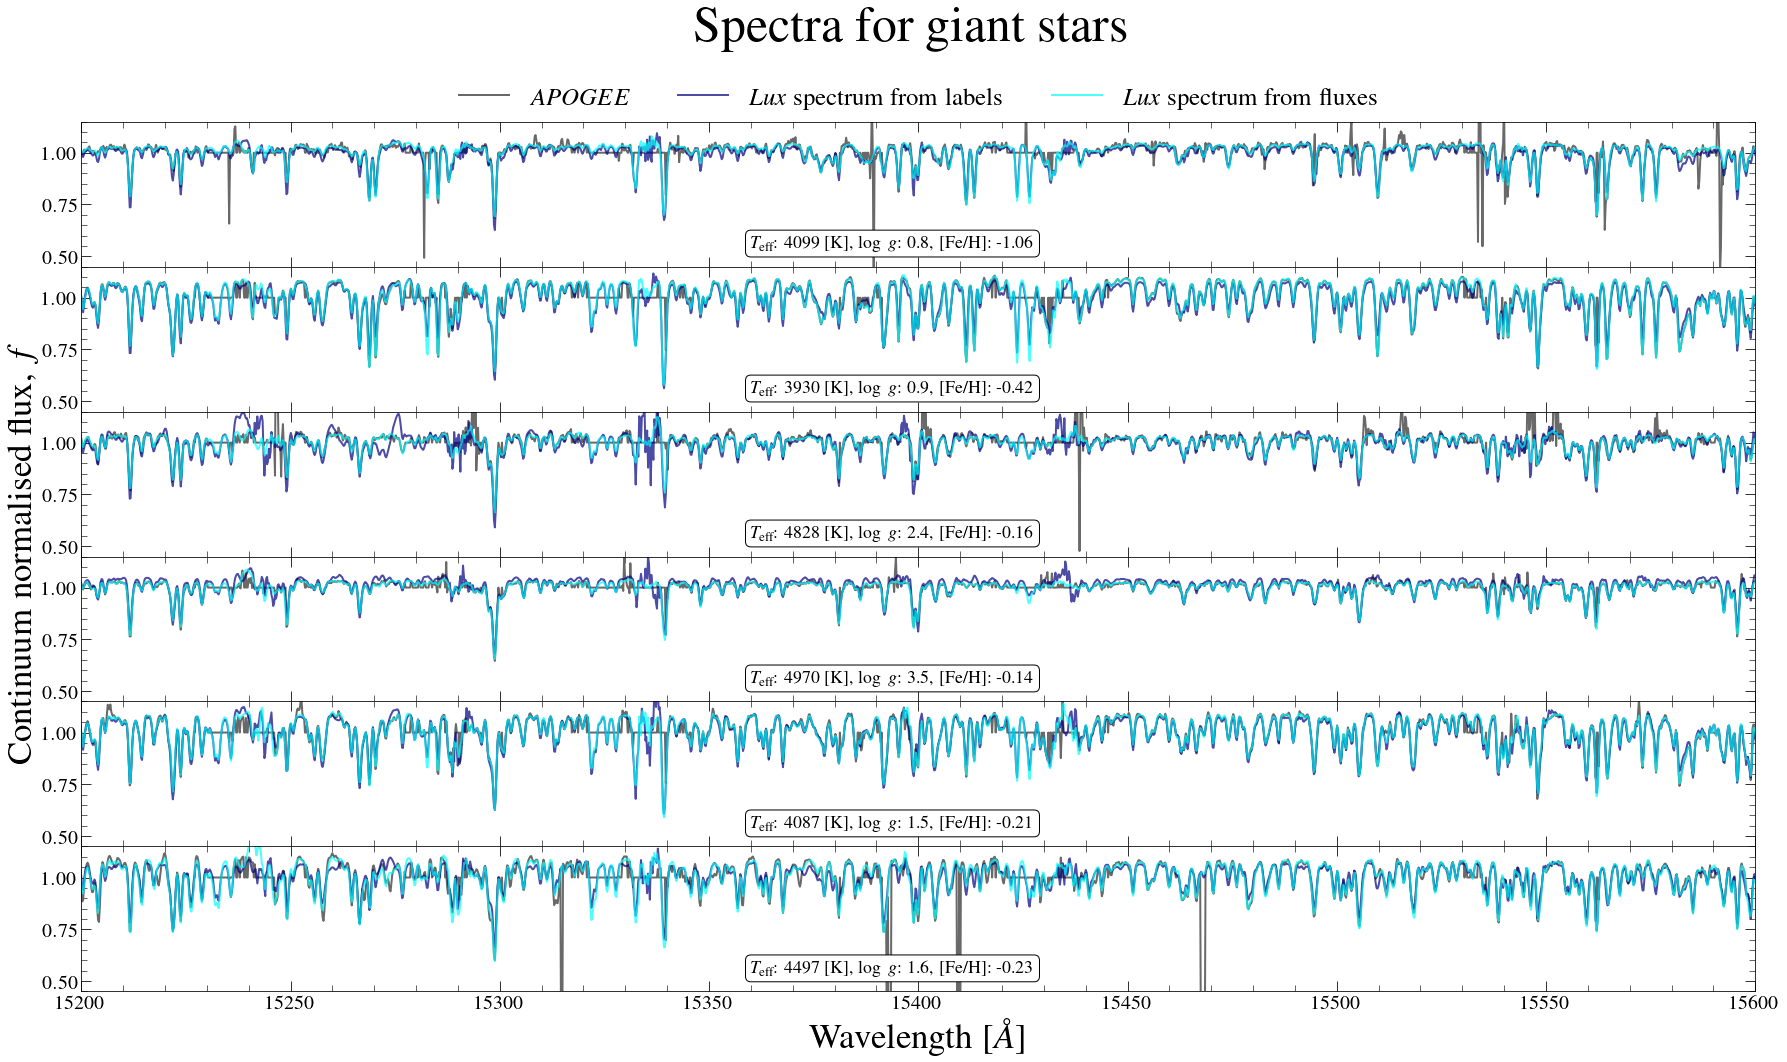

In [12]:
fig = plt.figure(figsize=(30,16), facecolor='white')
fig.suptitle('Spectra for giant stars',fontsize=50,x=0.51,y=0.98)

plt.subplot(6,1,1)
mask = (labels_test_fromlabels[:,0]>3900)&(labels_test_fromlabels[:,0]<4100)&(labels_test_fromlabels[:,1]>0.8)&(labels_test_fromlabels[:,1]<1.)&(labels_test_fromlabels[:,2]>-1.2)&(labels_test_fromlabels[:,2]<-1)
plt.plot(spectra_data['wl'],test_flux[mask][0], c='dimgray',lw=2, alpha=1, label=r'$APOGEE$')
plt.plot(spectra_data['wl'],spectra_test_fromlabels[mask][0], c='navy', lw=2, alpha=0.7, label='$Lux$ spectrum from labels')
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask][0], c='cyan', lw=2, alpha=0.7, label='$Lux$ spectrum from fluxes')
plt.xlim(15200,15600)
plt.ylim(0.45,1.15)
plt.legend(bbox_to_anchor=(0.5, 1.4), loc='upper center', ncol=3, fontsize=25, frameon=False)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(15360,0.6,'$T_{\mathrm{eff}}$: '+str("%.0f" % labels_test_fromlabels[:,0][mask][0])+' [K], '+\
         '$\log~g$: '+str("%.1f" % labels_test_fromlabels[:,1][mask][0])+ ', [Fe/H]: '+str("%.2f" % labels_test_fromlabels[:,2][mask][0]), fontsize=18, verticalalignment='top', bbox=props)
# plt.ylabel('Continuum normalised flux , $f$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, labelbottom=False)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
print(test_ID[mask][0])

plt.subplot(6,1,2)
mask = (labels_test_fromlabels[:,0]>3900)&(labels_test_fromlabels[:,0]<4100)&(labels_test_fromlabels[:,1]>0.8)&(labels_test_fromlabels[:,1]<1.)&(labels_test_fromlabels[:,2]>-0.5)&(labels_test_fromlabels[:,2]<-0.3)
plt.plot(spectra_data['wl'],test_flux[mask][0], c='dimgray',lw=2, alpha=1)
plt.plot(spectra_data['wl'],spectra_test_fromlabels[mask][0], c='navy', lw=2, alpha=0.7, label='$Paton$ spectrum from labels')
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask][0], c='cyan', lw=2, alpha=0.7, label='$Paton$ spectrum from fluxes')
plt.xlim(15200,15600)
plt.ylim(0.45,1.15)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(15360,0.6,'$T_{\mathrm{eff}}$: '+str("%.0f" % labels_test_fromlabels[:,0][mask][0])+' [K], '+\
         '$\log~g$: '+str("%.1f" % labels_test_fromlabels[:,1][mask][0])+ ', [Fe/H]: '+str("%.2f" % labels_test_fromlabels[:,2][mask][0]), fontsize=18, verticalalignment='top', bbox=props)
# plt.ylabel('Continuum normalised flux , $f$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, labelbottom=False)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
print(test_ID[mask][0])

plt.subplot(6,1,3)
mask = (labels_test_fromlabels[:,0]>4800)&(labels_test_fromlabels[:,0]<5000)&(labels_test_fromlabels[:,1]>2.4)&(labels_test_fromlabels[:,1]<2.6)&(labels_test_fromlabels[:,2]>-0.2)&(labels_test_fromlabels[:,2]<0.)
plt.plot(spectra_data['wl'],test_flux[mask][0], c='dimgray',lw=2, alpha=1)
plt.plot(spectra_data['wl'],spectra_test_fromlabels[mask][0], c='navy', lw=2, alpha=0.7, label='$Paton$ spectrum from labels')
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask][0], c='cyan', lw=2, alpha=0.7, label='$Paton$ spectrum from fluxes')
plt.xlim(15200,15600)
plt.ylim(0.45,1.15)
plt.ylabel('Continuum normalised flux, $f$', fontsize=35, y =0)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(15360,0.6,'$T_{\mathrm{eff}}$: '+str("%.0f" % labels_test_fromlabels[:,0][mask][0])+' [K], '+\
         '$\log~g$: '+str("%.1f" % labels_test_fromlabels[:,1][mask][0])+ ', [Fe/H]: '+str("%.2f" % labels_test_fromlabels[:,2][mask][0]), fontsize=18, verticalalignment='top', bbox=props)
# plt.ylabel('Continuum normalised flux , $f$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, labelbottom=False)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
print(test_ID[mask][0])

plt.subplot(6,1,4)
mask = (labels_test_fromlabels[:,0]>4800)&(labels_test_fromlabels[:,0]<5000)&(labels_test_fromlabels[:,1]>3.4)&(labels_test_fromlabels[:,1]<3.6)&(labels_test_fromlabels[:,2]>-0.2)&(labels_test_fromlabels[:,2]<0.)
plt.plot(spectra_data['wl'],test_flux[mask][0], c='dimgray',lw=2, alpha=1)
plt.plot(spectra_data['wl'],spectra_test_fromlabels[mask][0], c='navy', lw=2, alpha=0.7, label='$Paton$ spectrum from labels')
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask][0], c='cyan', lw=2, alpha=0.7, label='$Paton$ spectrum from fluxes')
plt.xlim(15200,15600)
plt.ylim(0.45,1.15)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(15360,0.6,'$T_{\mathrm{eff}}$: '+str("%.0f" % labels_test_fromlabels[:,0][mask][0])+' [K], '+\
         '$\log~g$: '+str("%.1f" % labels_test_fromlabels[:,1][mask][0])+ ', [Fe/H]: '+str("%.2f" % labels_test_fromlabels[:,2][mask][0]), fontsize=18, verticalalignment='top', bbox=props)
# plt.ylabel('Continuum normalised flux , $f$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, labelbottom=False)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
print(test_ID[mask][0])

plt.subplot(6,1,5)
mask = (labels_test_fromlabels[:,0]>3900)&(labels_test_fromlabels[:,0]<4100)&(labels_test_fromlabels[:,1]>1.4)&(labels_test_fromlabels[:,1]<1.6)&(labels_test_fromlabels[:,2]>-0.4)&(labels_test_fromlabels[:,2]<-0.2)
plt.plot(spectra_data['wl'],test_flux[mask][0], c='dimgray',lw=2, alpha=1)
plt.plot(spectra_data['wl'],spectra_test_fromlabels[mask][0], c='navy', lw=2, alpha=0.7, label='$Paton$ spectrum from labels')
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask][0], c='cyan', lw=2, alpha=0.7, label='$Paton$ spectrum from fluxes')
plt.xlim(15200,15600)
plt.ylim(0.45,1.15)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(15360,0.6,'$T_{\mathrm{eff}}$: '+str("%.0f" % labels_test_fromlabels[:,0][mask][0])+' [K], '+\
         '$\log~g$: '+str("%.1f" % labels_test_fromlabels[:,1][mask][0])+ ', [Fe/H]: '+str("%.2f" % labels_test_fromlabels[:,2][mask][0]), fontsize=18, verticalalignment='top', bbox=props)
# plt.ylabel('Continuum normalised flux , $f$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, labelbottom=False)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
print(test_ID[mask][0])

plt.subplot(6,1,6)
mask = (labels_test_fromlabels[:,0]>4400)&(labels_test_fromlabels[:,0]<4600)&(labels_test_fromlabels[:,1]>1.4)&(labels_test_fromlabels[:,1]<1.6)&(labels_test_fromlabels[:,2]>-0.4)&(labels_test_fromlabels[:,2]<-0.2)
plt.plot(spectra_data['wl'],test_flux[mask][0], c='dimgray',lw=2, alpha=1)
plt.plot(spectra_data['wl'],spectra_test_fromlabels[mask][0], c='navy', lw=2, alpha=0.7, label='$Paton$ spectrum from labels')
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask][0], c='cyan', lw=2, alpha=0.7, label='$Paton$ spectrum from fluxes')
plt.xlabel('Wavelength [$\AA$]', fontsize=35)
plt.xlim(15200,15600)
plt.ylim(0.45,1.15)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(15360,0.6,'$T_{\mathrm{eff}}$: '+str("%.0f" % labels_test_fromlabels[:,0][mask][0])+' [K], '+\
         '$\log~g$: '+str("%.1f" % labels_test_fromlabels[:,1][mask][0])+ ', [Fe/H]: '+str("%.2f" % labels_test_fromlabels[:,2][mask][0]), fontsize=18, verticalalignment='top', bbox=props)
# plt.ylabel('Continuum normalised flux , $f$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
print(test_ID[mask][0])


plt.subplots_adjust(hspace=0.)
plt.savefig('../plots/paper/spectra-diffstars-Lux.pdf',dpi=200, bbox_inches = 'tight')


# compute a chi-2 value for all stars using the spectra

In [39]:
chi2_spec = np.zeros((len(spectra_test_fromflux)))

for indx, i in tqdm.tqdm_notebook(enumerate(spectra_test_fromflux)):
    res = np.nansum((test_flux[indx] - i)**2 / (np.exp(ln_noise_fluxes_updated)**2 + test_flux_err[indx]**2))
    chi2_spec[indx] = res

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_10738/896239105.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for indx, i in tqdm.tqdm_notebook(enumerate(spectra_test_fromflux)):


0it [00:00, ?it/s]

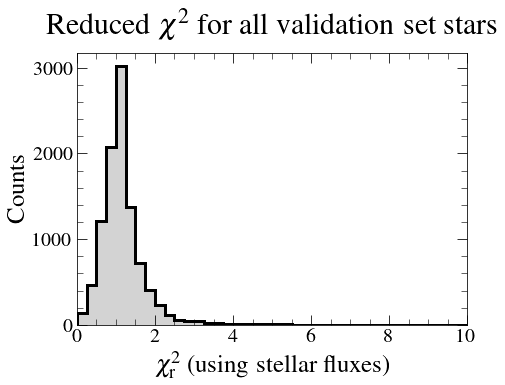

In [79]:
plt.figure(figsize=(7,5), facecolor='white', rasterized=True)

plt.title(r'Reduced $\chi^{2}$ for all validation set stars', fontsize=30, pad=20)

plt.hist(chi2_spec/spectra_test_fromflux.shape[1], np.linspace(0,10,41), color='lightgray');
plt.hist(chi2_spec/spectra_test_fromflux.shape[1], np.linspace(0,10,41), color='k', histtype='step', lw=3);
plt.xlabel('$\chi^{2}_{\mathrm{r}}$ (using stellar fluxes)', fontsize=25)
plt.ylabel('Counts', fontsize=25)
plt.xlim(0,10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('../plots/paper/spectra-reduced-chi2.pdf',dpi=200, bbox_inches = 'tight')


Text(0.5, 0, '$T_{\\mathrm{eff}}$ [K]')

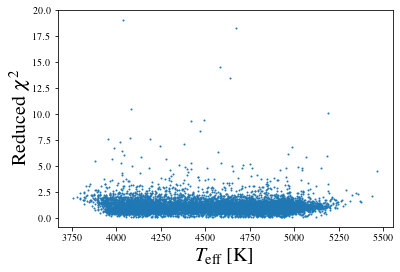

In [41]:
plt.scatter(labels_test_fromflux[:,0],chi2_spec/spectra_test_fromflux.shape[1], s=1)
plt.ylabel('Reduced $\chi^{2}$', fontsize=20)
plt.xlabel('$T_{\mathrm{eff}}$ [K]', fontsize=20)

# find two stars with the same stellar parameters but different abundances and show the different lines

In [43]:
mask = (labels_test_fromflux[:,0]>4500)&(labels_test_fromflux[:,0]<4600)&(labels_test_fromflux[:,1]>2)&(labels_test_fromflux[:,1]<2.5)&(labels_test_fromflux[:,2]>-0.6)&(labels_test_fromflux[:,2]<-0.4)
print(labels_test_fromflux[:,0][mask][0], labels_test_fromflux[:,1][mask][0], labels_test_fromflux[:,2][mask][0])

4532.756720918835 2.077280135481825 -0.500023280731145


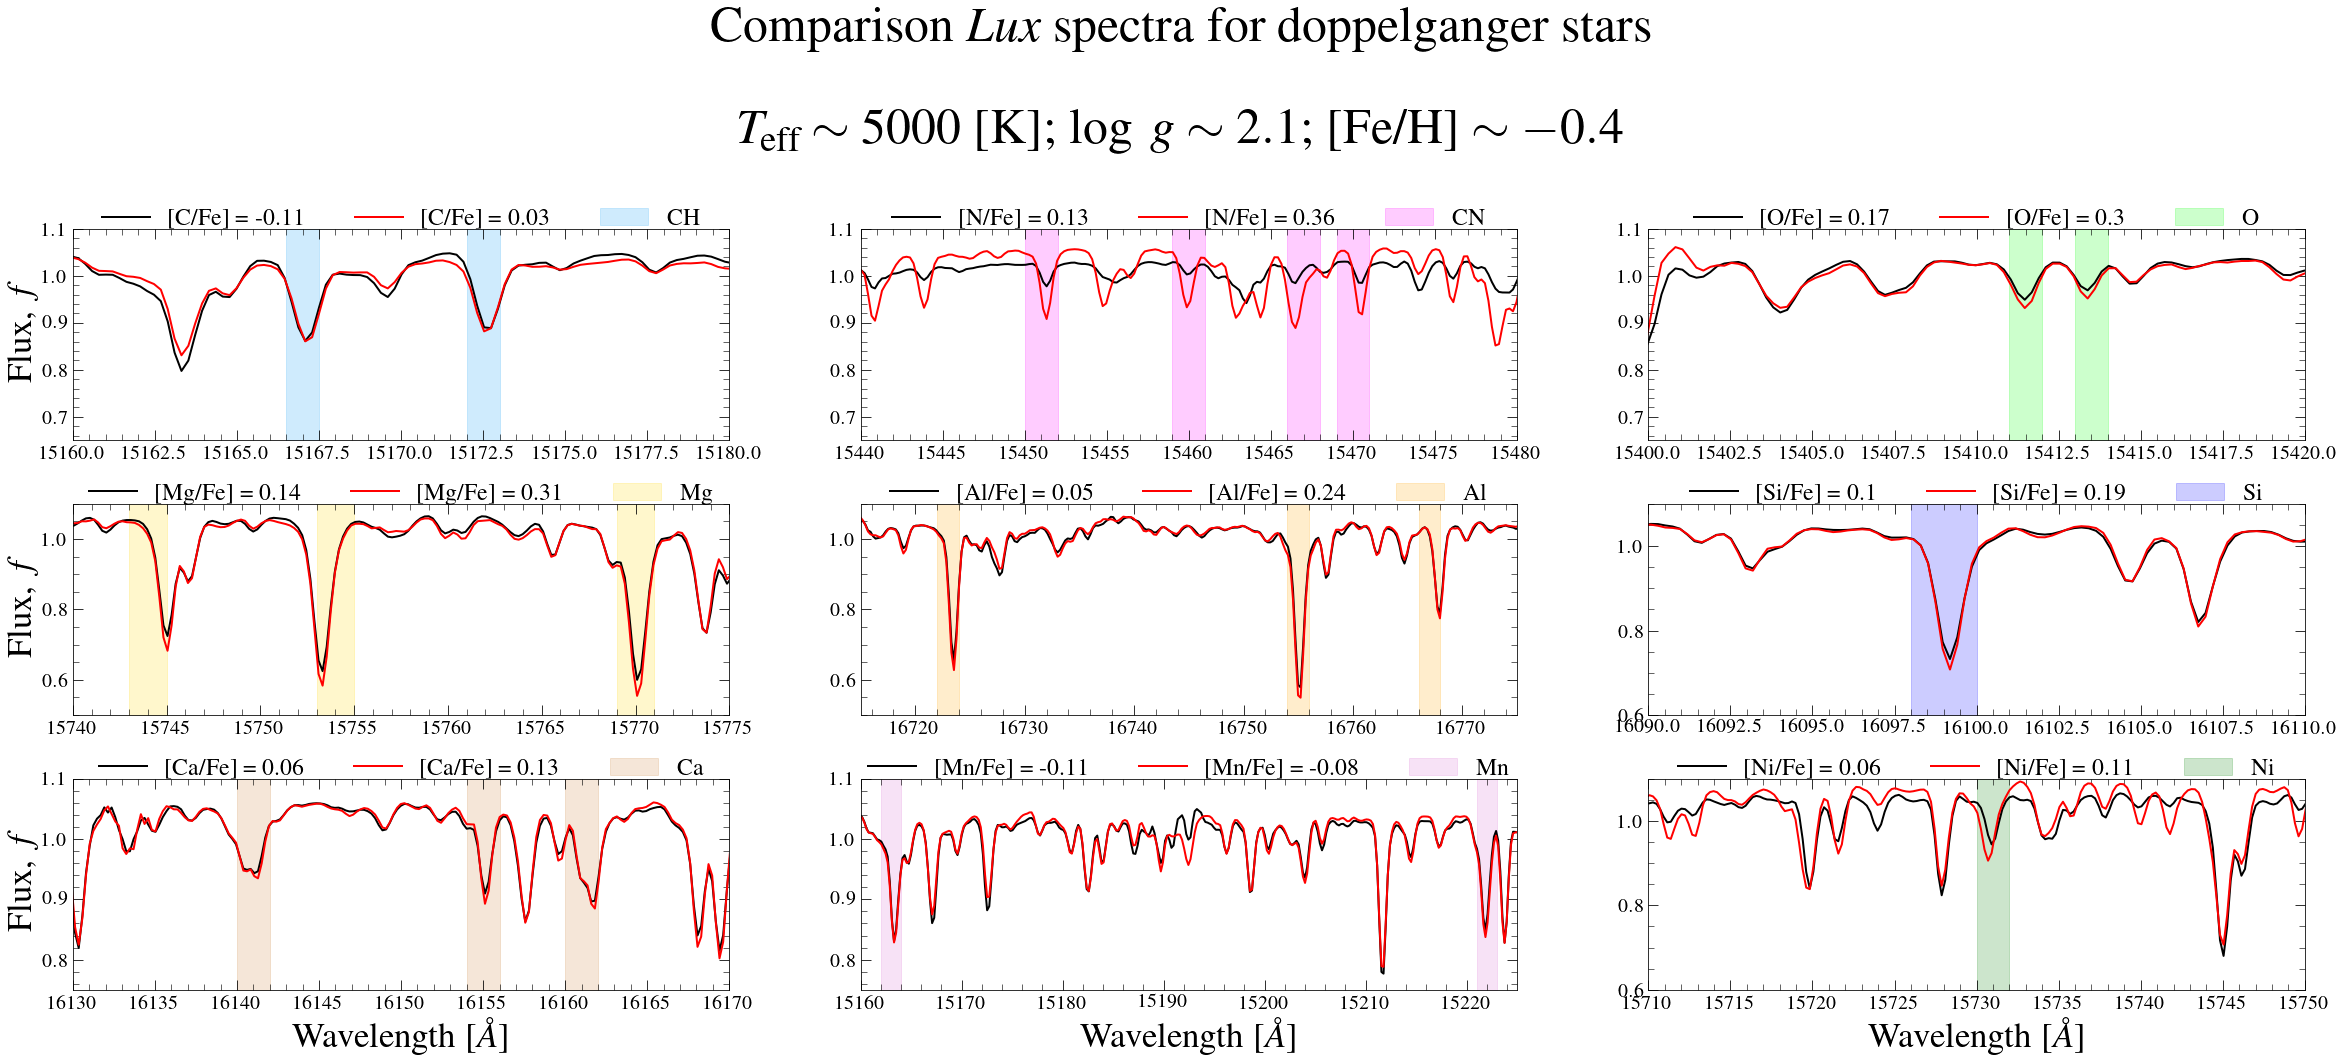

In [13]:
mask = (labels_test_fromflux[:,0]>4500)&(labels_test_fromflux[:,0]<4600)&(labels_test_fromflux[:,1]>2)&(labels_test_fromflux[:,1]<2.5)&(labels_test_fromflux[:,2]>-0.6)&(labels_test_fromflux[:,2]<-0.4)

fig = plt.figure(figsize=(40,14), facecolor='white', rasterized=True)
fig.suptitle('Comparison $Lux$ spectra for doppelganger stars \n \n $T_{\mathrm{eff}} \sim 5000$ [K]; $\log~g \sim 2.1;$ [Fe/H] $\sim -0.4$',fontsize=50,x=0.51,y=1.1)

plt.subplot(3,3,1)
i = 3
mask_abun1 = (labels_test_fromflux[:,i]>-0.2)&(labels_test_fromflux[:,i]<-0.1)&(labels_test_fromflux[:,4]>0.1)&(labels_test_fromflux[:,4]<0.3)
mask_abun2 = (labels_test_fromflux[:,i]>0.)&(labels_test_fromflux[:,i]<0.1)&(labels_test_fromflux[:,4]>0.1)&(labels_test_fromflux[:,4]<0.3)
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun1][0], c='k', lw=2, label='[C/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun1][0],2)))
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun2][0], c='r', lw=2,  label='[C/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun2][0],2)))
plt.xlim(15160,15180)
plt.ylim(0.65,1.1)
plt.fill_betweenx(np.linspace(0.,1.2,32),15166.5, 15167.5, color='lightskyblue',alpha=0.4, label='CH') #CN
plt.fill_betweenx(np.linspace(0.,1.2,32),15172, 15173, color='lightskyblue',alpha=0.4) #CN
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, pad=5)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=3, fontsize=24, frameon=False)
plt.ylabel('Flux, $f$', fontsize=35)

plt.subplot(3,3,2)
i = 4
mask_abun1 = (labels_test_fromflux[:,i]>0.1)&(labels_test_fromflux[:,i]<0.2)&(labels_test_fromflux[:,3]>0.)&(labels_test_fromflux[:,3]<0.4)
mask_abun2 = (labels_test_fromflux[:,i]>0.3)&(labels_test_fromflux[:,i]<0.4)&(labels_test_fromflux[:,3]>0.)&(labels_test_fromflux[:,3]<0.4)
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun1][0], c='k', lw=2, label='[N/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun1][0],2)))
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun2][0], c='r', lw=2,  label='[N/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun2][0],2)))
plt.xlim(15440,15480)
plt.ylim(0.65,1.1)
plt.fill_betweenx(np.linspace(0.,1.2,32),15459, 15461, color='magenta',alpha=0.2, label='CN') #CH
plt.fill_betweenx(np.linspace(0.,1.2,32),15450, 15452, color='magenta',alpha=0.2) #CH
plt.fill_betweenx(np.linspace(0.,1.2,32),15469, 15471, color='magenta',alpha=0.2) #CH
plt.fill_betweenx(np.linspace(0.,1.2,32),15466, 15468, color='magenta',alpha=0.2) #CH
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, pad=5)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=3, fontsize=24, frameon=False)


plt.subplot(3,3,3)
i = 5
mask_abun1 = (labels_test_fromflux[:,i]>0.1)&(labels_test_fromflux[:,i]<0.2)
mask_abun2 = (labels_test_fromflux[:,i]>0.3)&(labels_test_fromflux[:,i]<0.4)
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun1][0], c='k', lw=2, label='[O/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun1][0],2)))
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun2][0], c='r', lw=2,  label='[O/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun2][0],2)))
plt.xlim(15400,15420)
plt.ylim(0.65,1.1)
plt.fill_betweenx(np.linspace(0.,1.2,32),15411, 15412, color='lime',alpha=0.2, label='O') # O I
plt.fill_betweenx(np.linspace(0.,1.2,32),15413, 15414, color='lime',alpha=0.2) # O I
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, pad=5)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=3, fontsize=24, frameon=False)


plt.subplot(3,3,4)
i = 6
mask_abun1 = (labels_test_fromflux[:,i]>0.1)&(labels_test_fromflux[:,i]<0.2)
mask_abun2 = (labels_test_fromflux[:,i]>0.3)&(labels_test_fromflux[:,i]<0.4)
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun1][0], c='k', lw=2, label='[Mg/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun1][0],2)))
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun2][0], c='r', lw=2,  label='[Mg/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun2][0],2)))
plt.xlim(15740,15775)
plt.ylim(0.5,1.1)
plt.fill_betweenx(np.linspace(0.,1.2,32),15743, 15745, color='gold',alpha=0.2, label='Mg') #CH
plt.fill_betweenx(np.linspace(0.,1.2,32),15753, 15755, color='gold',alpha=0.2) #CH
plt.fill_betweenx(np.linspace(0.,1.2,32),15769, 15771, color='gold',alpha=0.2) #CH
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, pad=5)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=3, fontsize=24, frameon=False)
plt.ylabel('Flux, $f$', fontsize=35)

plt.subplot(3,3,5)
i = 7
mask_abun1 = (labels_test_fromflux[:,i]>-0.5)&(labels_test_fromflux[:,i]<0.05)
mask_abun2 = (labels_test_fromflux[:,i]>0.15)&(labels_test_fromflux[:,i]<0.25)
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun1][0], c='k', lw=2, label='[Al/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun1][0],2)))
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun2][0], c='r', lw=2,  label='[Al/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun2][0],2)))
plt.xlim(16715,16775)
plt.ylim(0.5,1.1)
plt.fill_betweenx(np.linspace(0.,1.2,32),16722, 16724, color='orange',alpha=0.2, label='Al') #CH
plt.fill_betweenx(np.linspace(0.,1.2,32),16754, 16756, color='orange',alpha=0.2) # O I
plt.fill_betweenx(np.linspace(0.,1.2,32),16766, 16768, color='orange',alpha=0.2) # O I
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, pad=5)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=3, fontsize=24, frameon=False)

plt.subplot(3,3,6)
i = 8
mask_abun1 = (labels_test_fromflux[:,i]>0.)&(labels_test_fromflux[:,i]<0.1)
mask_abun2 = (labels_test_fromflux[:,i]>0.1)&(labels_test_fromflux[:,i]<0.2)
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun1][0], c='k', lw=2, label='[Si/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun1][0],2)))
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun2][0], c='r', lw=2,  label='[Si/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun2][0],2)))
plt.xlim(16090,16110)
plt.ylim(0.6,1.1)
plt.fill_betweenx(np.linspace(0.,1.2,32),16098, 16100, color='b',alpha=0.2, label='Si') #CH
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, pad=5)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=3, fontsize=24, frameon=False)


plt.subplot(3,3,7)
i = 9
mask_abun1 = (labels_test_fromflux[:,i]>0.)&(labels_test_fromflux[:,i]<0.1)
mask_abun2 = (labels_test_fromflux[:,i]>0.1)&(labels_test_fromflux[:,i]<0.2)
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun1][0], c='k', lw=2, label='[Ca/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun1][0],2)))
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun2][0], c='r', lw=2,  label='[Ca/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun2][0],2)))
plt.xlim(16130, 16170)
plt.ylim(0.75,1.1)
plt.fill_betweenx(np.linspace(0.,1.2,32),16140, 16142, color='peru',alpha=0.2, label='Ca') #CH
plt.fill_betweenx(np.linspace(0.,1.2,32),16154, 16156, color='peru',alpha=0.2) #CH
plt.fill_betweenx(np.linspace(0.,1.2,32),16160, 16162, color='peru',alpha=0.2) #CH
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, pad=5)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=3, fontsize=24, frameon=False)
plt.xlabel('Wavelength [$\AA$]', fontsize=35)
plt.ylabel('Flux, $f$', fontsize=35)


plt.subplot(3,3,8)
i = 10
mask_abun1 = (labels_test_fromflux[:,i]>-0.2)&(labels_test_fromflux[:,i]<-0.1)
mask_abun2 = (labels_test_fromflux[:,i]>-0.1)&(labels_test_fromflux[:,i]<0.)
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun1][0], c='k', lw=2, label='[Mn/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun1][0],2)))
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun2][0], c='r', lw=2,  label='[Mn/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun2][0],2)))
plt.xlim(15160,15225)
plt.ylim(0.75,1.1)
plt.fill_betweenx(np.linspace(0.,1.2,32),15162, 15164, color='orchid',alpha=0.2, label='Mn') #CH
plt.fill_betweenx(np.linspace(0.,1.2,32),15221, 15223, color='orchid',alpha=0.2) #CH
plt.fill_betweenx(np.linspace(0.,1.2,32),15265, 15267, color='orchid',alpha=0.2) #CH
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, pad=5)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=3, fontsize=24, frameon=False)
plt.xlabel('Wavelength [$\AA$]', fontsize=35)


plt.subplot(3,3,9)
i = 11
mask_abun1 = (labels_test_fromflux[:,i]>0)&(labels_test_fromflux[:,i]<0.1)
mask_abun2 = (labels_test_fromflux[:,i]>0.1)&(labels_test_fromflux[:,i]<0.2)
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun1][0], c='k', lw=2, label='[Ni/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun1][0],2)))
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask&mask_abun2][0], c='r', lw=2,  label='[Ni/Fe] = '+str(round(labels_test_fromflux[:,i][mask&mask_abun2][0],2)))
plt.xlim(15710,15750)
plt.ylim(0.6,1.1)
plt.fill_betweenx(np.linspace(0.,1.2,32),15730, 15732, color='g',alpha=0.2, label='Ni') #CH
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, pad=5)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=3, fontsize=24, frameon=False)
plt.xlabel('Wavelength [$\AA$]', fontsize=35)

plt.subplots_adjust(hspace=0.3)
plt.savefig('../plots/paper/comp-spectra-Lux.pdf',dpi=200, bbox_inches = 'tight')



# make some fun spectra plots for talks

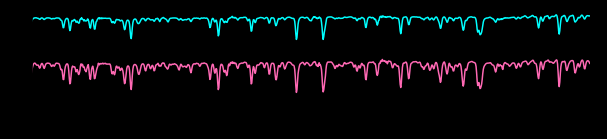

In [15]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(spectra_test_fromflux[99], color='cyan')
ax.plot(spectra_test_fromflux[199]-0.5, color='hotpink')
ax.set_xlim(2000,3000)
fig.patch.set_facecolor('black')  # Figure background
ax.set_facecolor('black')    

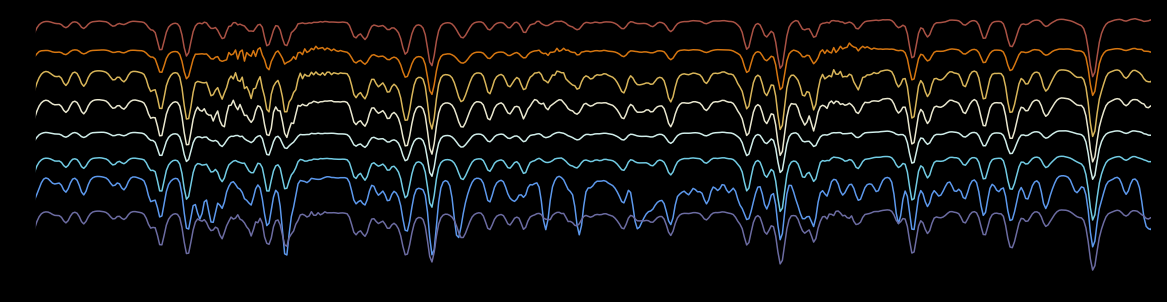

In [151]:
niter = 8
offsets = np.linspace(0,1,niter)

cmap = cm.prinsenvlag  # Choose a colormap
norm = mcolors.Normalize(vmin=offsets.min(), vmax=offsets.max())  # Normalize slopes

# Create the figure and axes
fig, ax = plt.subplots(figsize=(20,5))

for i in range(niter):
    color = cmap(norm(offsets[i]))  # Map slope to a color
    ax.plot(spectra_test_fromflux[i]-offsets[i], color=color)
    ax.set_xlim(2000,2500)
    ax.set_ylim(offsets.min()-0.3, offsets.max()+0.1)
# Set the figure and axes background to black
fig.patch.set_facecolor('black')  # Figure background
ax.set_facecolor('black')    


# COMPUTE DERIVATIVE SPECTRA

In [17]:
# l = z @ a.T --> z = l @ np.linalg.pinv(alphas.T)
# f = z @ b.T --> f = l @ np.linalg.pinv(alphas.T) @ b.T
# df/dl = np.linalg.pinv(alphas.T) @ b.T
deriv_fluxes_labels = (np.linalg.pinv(alphas.T) @ betas.T).T
deriv_labels_fluxes = (np.linalg.pinv(betas.T) @ alphas.T).T

deriv_fluxes_labels.shape, deriv_labels_fluxes.shape

((8575, 12), (12, 8575))

2M00011399+8408446


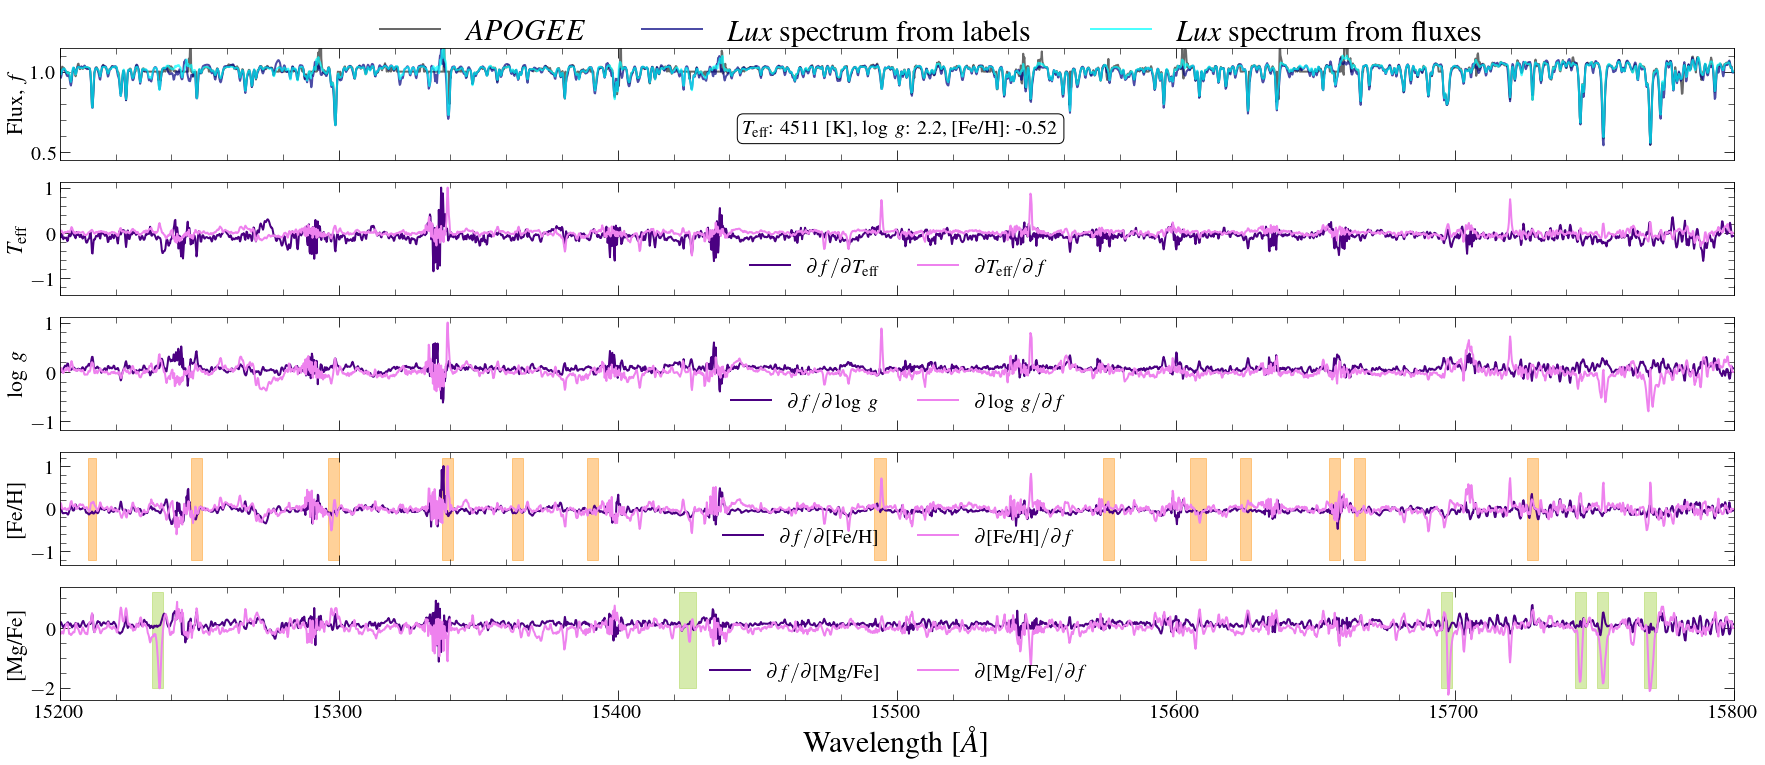

In [18]:
fig = plt.figure(figsize=(30,12), facecolor='white', rasterized=True)

mask = (labels_test_fromflux[:,0]>4500)&(labels_test_fromflux[:,0]<4600)&(labels_test_fromflux[:,1]>2)&(labels_test_fromflux[:,1]<2.5)&(labels_test_fromflux[:,2]>-0.6)&(labels_test_fromflux[:,2]<-0.4)

print(test_ID[mask][0])
plt.subplot(5,1,1)
plt.plot(spectra_data['wl'],test_flux[mask][0], c='dimgray',lw=2, alpha=1, label='$APOGEE$')
plt.plot(spectra_data['wl'],spectra_test_fromlabels[mask][0], c='navy', lw=2, alpha=0.7, label='$Lux$ spectrum from labels')
plt.plot(spectra_data['wl'],spectra_test_fromflux[mask][0], c='cyan', lw=2, alpha=0.7, label='$Lux$ spectrum from fluxes')
plt.xlim(15200,15800)
plt.ylim(0.45,1.15)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(15445,0.7,'$T_{\mathrm{eff}}$: '+str("%.0f" % labels_test_fromlabels[:,0][mask][0])+' [K], '+\
         '$\log~g$: '+str("%.1f" % labels_test_fromlabels[:,1][mask][0])+ ', [Fe/H]: '+str("%.2f" % labels_test_fromlabels[:,2][mask][0]), fontsize=20, verticalalignment='top', bbox=props)
plt.legend(bbox_to_anchor=(0.52, 1.5), loc='upper center', ncol=3, fontsize=30, frameon=False)
plt.ylabel('Flux, $f$', fontsize=22)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, labelbottom=False)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(5,1,2)
plt.plot(spectra_data['wl'], deriv_fluxes_labels[:,0]/deriv_fluxes_labels[:,0].max(), c='indigo', lw=2, label='$\partial f/\partial T_{\mathrm{eff}}$')
plt.plot(spectra_data['wl'], deriv_labels_fluxes[0]/deriv_labels_fluxes[0].max(), c='violet', lw=2, label='$\partial T_{\mathrm{eff}}/\partial f$')
plt.xlim(15200,15800)
plt.ylabel('$T_{\mathrm{eff}}$', fontsize=22)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, labelbottom=False)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(loc='lower center', fontsize=20, frameon=False, ncols=2)

plt.subplot(5,1,3)
plt.plot(spectra_data['wl'], deriv_fluxes_labels[:,1]/deriv_fluxes_labels[:,1].max(), c='indigo', lw=2, label='$\partial f/\partial \log~g$')
plt.plot(spectra_data['wl'], deriv_labels_fluxes[1]/deriv_labels_fluxes[1].max(), c='violet', lw=2, label='$\partial \log~g/\partial f$')
plt.xlim(15200,15800)
plt.ylabel('$\log~g$', fontsize=22)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, labelbottom=False)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(loc='lower center', fontsize=20, frameon=False, ncols=2)

plt.subplot(5,1,4)
plt.plot(spectra_data['wl'], deriv_fluxes_labels[:,2]/deriv_fluxes_labels[:,2].max(), c='indigo', lw=2, label='$\partial f/\partial$[Fe/H]')
plt.plot(spectra_data['wl'], deriv_labels_fluxes[2]/deriv_labels_fluxes[2].max(), c='violet', lw=2, label='$\partial$[Fe/H]$/\partial f$')
plt.xlim(15200,15800)
plt.ylabel('[Fe/H]', fontsize=22)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, labelbottom=False)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(loc='lower center', fontsize=20, frameon=False, ncols=2)
plt.fill_betweenx(np.linspace(-1.2,1.2,32),15210, 15213, color='darkorange',alpha=0.4, label='Fe I') #Fe I
plt.fill_betweenx(np.linspace(-1.2,1.2,32),15247, 15251, color='darkorange',alpha=0.4) #Fe I
plt.fill_betweenx(np.linspace(-1.2,1.2,32),15296, 15300, color='darkorange',alpha=0.4) #Fe I
plt.fill_betweenx(np.linspace(-1.2,1.2,32),15362, 15366, color='darkorange',alpha=0.4) #Fe I
plt.fill_betweenx(np.linspace(-1.2,1.2,32),15389, 15393, color='darkorange',alpha=0.4) #Fe I
plt.fill_betweenx(np.linspace(-1.2,1.2,32),15337, 15341, color='darkorange',alpha=0.4) #Fe I
plt.fill_betweenx(np.linspace(-1.2,1.2,32),15574, 15578, color='darkorange',alpha=0.4) #Fe I
plt.fill_betweenx(np.linspace(-1.2,1.2,32),15492, 15496, color='darkorange',alpha=0.4) #Fe I
plt.fill_betweenx(np.linspace(-1.2,1.2,32),15605, 15611, color='darkorange',alpha=0.4) #Fe I
plt.fill_betweenx(np.linspace(-1.2,1.2,32),15623, 15627, color='darkorange',alpha=0.4) #Fe I
plt.fill_betweenx(np.linspace(-1.2,1.2,32),15655, 15659, color='darkorange',alpha=0.4) #Fe I
plt.fill_betweenx(np.linspace(-1.2,1.2,32),15664, 15668, color='darkorange',alpha=0.4) #Fe I
plt.fill_betweenx(np.linspace(-1.2,1.2,32),15726, 15730, color='darkorange',alpha=0.4) #Fe I

plt.subplot(5,1,5)
plt.plot(spectra_data['wl'], deriv_fluxes_labels[:,6]/deriv_fluxes_labels[:,6].max(), c='indigo', lw=2, label='$\partial f/\partial$[Mg/Fe]')
plt.plot(spectra_data['wl'], deriv_labels_fluxes[6]/deriv_labels_fluxes[6].max(), c='violet', lw=2, label='$\partial$[Mg/Fe]$/\partial f$')
plt.xlim(15200,15800)
plt.ylabel('[Mg/Fe]', fontsize=22)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.legend(loc='lower center', fontsize=20, frameon=False, ncols=2)
plt.fill_betweenx(np.linspace(-2,1.2,32), 15233,15237, color='yellowgreen' ,alpha=0.4, label='Mg I') #Mg I
plt.fill_betweenx(np.linspace(-2,1.2,32), 15422,15428, color='yellowgreen' ,alpha=0.4) #Mg I
plt.fill_betweenx(np.linspace(-2,1.2,32), 15695,15699, color='yellowgreen' ,alpha=0.4) #Mg I
plt.fill_betweenx(np.linspace(-2,1.2,32), 15743,15747, color='yellowgreen' ,alpha=0.4) #Mg I
plt.fill_betweenx(np.linspace(-2,1.2,32), 15768,15772, color='yellowgreen' ,alpha=0.4) #Mg I
plt.fill_betweenx(np.linspace(-2,1.2,32), 15751,15755, color='yellowgreen' ,alpha=0.4) #Mg I

plt.xlabel('Wavelength [$\AA$]', fontsize=30)
plt.savefig('../plots/paper/deriv-spectra-Lux.pdf',dpi=200, bbox_inches = 'tight')



In [ ]:
# plt.fill_betweenx(np.linspace(0.4,1.2,32), 15202,15206, color='lime' ,alpha=0.4) #CN
# plt.text(15206.5,0.6, 'Ni', fontsize=16) 
# plt.fill_betweenx(np.linspace(0.4,1.2,32), 15248,15252, color='orchid' ,alpha=0.4) #CN
# plt.text(15253,0.6, 'CN', fontsize=16) 
# plt.fill_betweenx(np.linspace(0.4,1.2,32), 15276,15280, color='gold' ,alpha=0.4) #OH
# plt.text(15281,0.6, 'OH', fontsize=16) 
# plt.fill_betweenx(np.linspace(0.4,1.2,32),15210, 15213, color='k',alpha=0.4) #Fe I
# plt.text(15214,0.6, 'Fe I', fontsize=16) 
# plt.fill_betweenx(np.linspace(0.4,1.2,32), 15359,15363, color='darkorchid' ,alpha=0.4) #Si I
# plt.text(15364,0.6, 'Si I', fontsize=16) 
# plt.fill_betweenx(np.linspace(0.4,1.2,32), 15162,15164, color='darkorange' ,alpha=0.4) #Mn I
# plt.text(15165,0.6, 'Mn I', fontsize=16) 
# plt.legend(bbox_to_anchor=(0.47, 1.6), loc="upper center", fontsize=30, frameon=False, ncols=2)
# plt.fill_betweenx(np.linspace(0.4,1.2,32), 15592,15600, color='dodgerblue' ,alpha=0.4) #CO
# plt.text(15601,0.6, 'CO', fontsize=16) 
# plt.fill_betweenx(np.linspace(0.4,1.2,32), 15743,15747, color='g' ,alpha=0.4) #Mg I
# plt.text(15736,0.6, 'Mg I', fontsize=16) 
# plt.fill_betweenx(np.linspace(0.4,1.2,32),16040, 16050, color='k',alpha=0.4) #Fe I
# plt.text(16051,0.6, 'Fe I', fontsize=16) 
# plt.fill_betweenx(np.linspace(0.4,1.2,32), 16139,16143, color='navy' ,alpha=0.4) #Ca I
# plt.text(16144,0.6, 'Ca I', fontsize=16) 
# plt.fill_betweenx(np.linspace(0.4,1.2,32), 16722,16725, color='gray' ,alpha=0.4) #Al I
# plt.text(16726,0.6, 'Al I', fontsize=16) 